In [3]:
import os 
import matplotlib as plt
import PIL as Image 
import numpy as np

import pandas as pd
import cv2

import tifffile

import imageio.v3 as iio
import matplotlib.pyplot as plt


Image shape: (128, 128, 12)


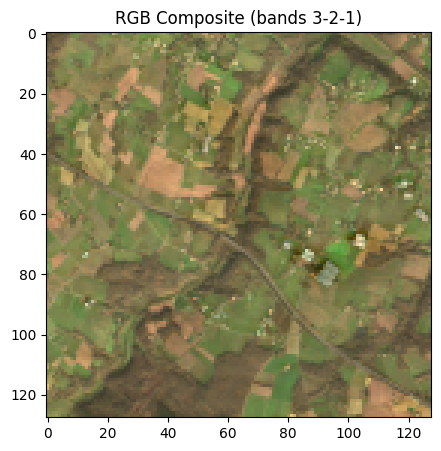

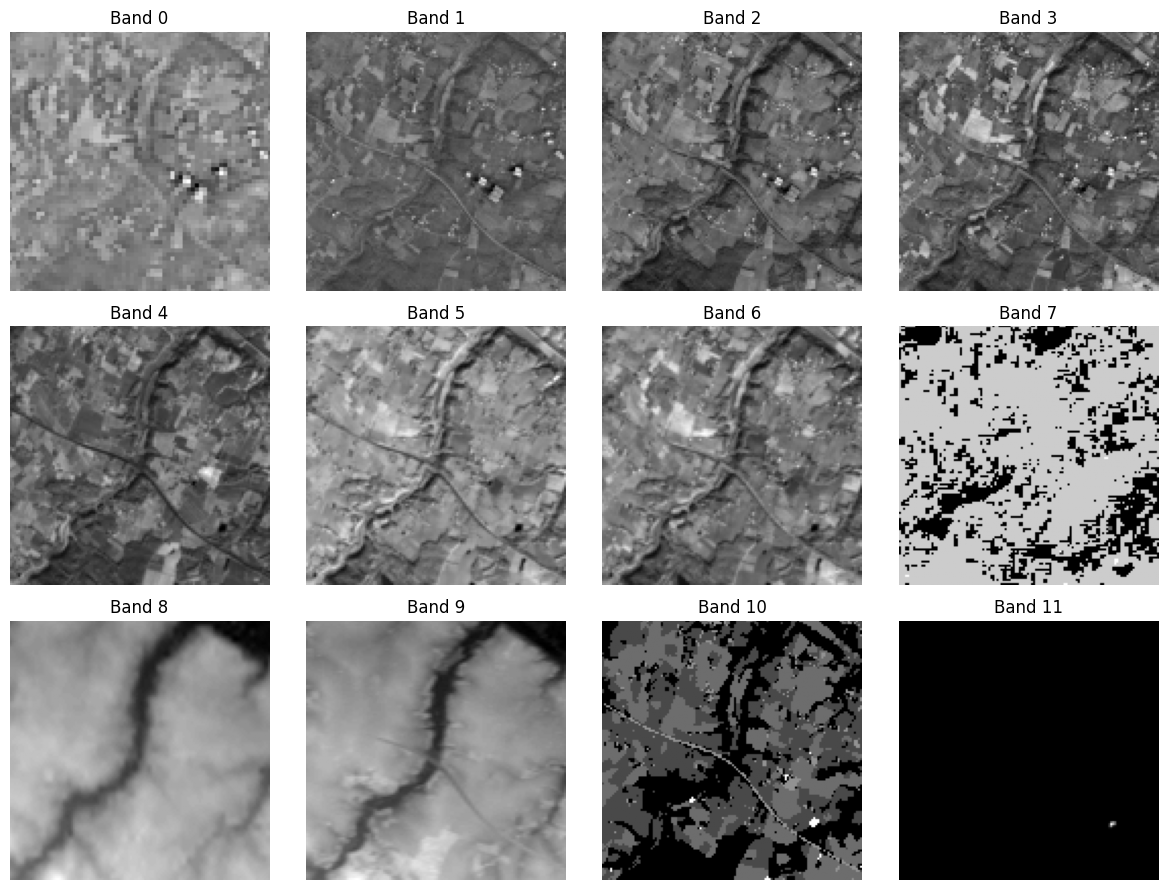

In [4]:
path = r"D:\cellula\task_2\data\images\7.tif"
img = tifffile.imread(path).astype(np.float32)  # shape (H, W, C)

print("Image shape:", img.shape)
'''''
# 1. Show a single band (e.g., band 0)
plt.figure(figsize=(5,5))
plt.imshow(img[:,:,0], cmap="gray")
plt.title("Band 0")
plt.colorbar()
plt.show()
'''''
# 2. Make an RGB composite (choose 3 bands, e.g., [3,2,1])
# NOTE: adjust band numbers depending on dataset
rgb = img[:,:, [3,2,1]]
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())  # normalize to [0,1]

plt.figure(figsize=(5,5))
plt.imshow(rgb)
plt.title("RGB Composite (bands 3-2-1)")
plt.show()

# 3. Display all 12 bands in a grid
fig, axes = plt.subplots(3, 4, figsize=(12,9))
for i in range(12):
    ax = axes[i//4, i%4]
    ax.imshow(img[:,:,i], cmap="gray")
    ax.set_title(f"Band {i}")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [5]:
train_image_dir=r"D:\cellula\task_2\data\images"
train_mask_dir=r"D:\cellula\task_2\data\labels"

In [6]:
import os

train_image_dir = r"D:\cellula\task_2\data\images"
train_mask_dir  = r"D:\cellula\task_2\data\labels"

# Collect pairs (assumes mask has same name as image)
image_files = sorted([f for f in os.listdir(train_image_dir) if f.endswith((".tif", ".png"))])
mask_files  = sorted([f for f in os.listdir(train_mask_dir) if f.endswith((".tif", ".png"))])

pairs = []
for img_file in image_files:
    mask_file = img_file.replace(".tif", ".png") if img_file.endswith(".tif") else img_file
    mask_path = os.path.join(train_mask_dir, mask_file)
    img_path  = os.path.join(train_image_dir, img_file)

    if os.path.exists(mask_path):
        pairs.append((img_path, mask_path))
    else:
        print(f"⚠️ No mask found for {img_file}")

print(f"Total pairs: {len(pairs)}")


Total pairs: 306


In [7]:
import os
import numpy as np
import tifffile
from PIL import Image

class UNetDataGenerator12:
    def __init__(self, image_dir, mask_dir, batch_size=8, target_size=(128,128), shuffle=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle

        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".tif")])
        self.indexes = np.arange(len(self.image_files))

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __iter__(self):
        while True:
            if self.shuffle:
                np.random.shuffle(self.indexes)

            for start in range(0, len(self.indexes), self.batch_size):
                batch_idx = self.indexes[start:start+self.batch_size]
                images, masks = [], []

                for i in batch_idx:
                    img_file = self.image_files[i]
                    mask_file = img_file.replace(".tif", ".png")

                    # --- load image with tifffile ---
                    img = tifffile.imread(os.path.join(self.image_dir, img_file)).astype(np.float32)  # shape: H,W,C

                    # ensure we have 12 channels (pad if less)
                    if img.ndim == 2:
                        img = np.stack([img]*12, axis=-1)
                    elif img.ndim == 3 and img.shape[-1] < 12:
                        pad_width = 12 - img.shape[-1]
                        img = np.concatenate([img, np.zeros((*img.shape[:2], pad_width), dtype=img.dtype)], axis=-1)
                    elif img.ndim == 3 and img.shape[-1] > 12:
                        img = img[..., :12]

                    # normalize each channel to [0,1]
                    img = img / np.max(img, axis=(0,1), keepdims=True)

                    # resize all channels
                    img_resized = []
                    for ch in range(12):
                        ch_img = Image.fromarray((img[..., ch]*255).astype(np.uint8))
                        ch_img = ch_img.resize(self.target_size, Image.Resampling.BILINEAR)
                        img_resized.append(np.array(ch_img, dtype=np.float32)/255.0)
                    img = np.stack(img_resized, axis=-1)

                    # load mask
                    mask = Image.open(os.path.join(self.mask_dir, mask_file)).convert("L")
                    mask = mask.resize(self.target_size, Image.Resampling.NEAREST)
                    mask = np.array(mask, dtype=np.float32)/255.0
                    mask = np.expand_dims(mask, axis=-1)

                    images.append(img)
                    masks.append(mask)

                yield np.stack(images, axis=0), np.stack(masks, axis=0)


In [8]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras import layers , Model, Input



def unet_model(input_size=(128,128)):
    inputs =Input(input_size)


    c1 =layers.Conv2D(64, (3,3), activation="relu", padding="same")(inputs)
    c1 =layers.Conv2D(64, (3,3), activation="relu", padding="same")(c1)
    p1 =layers.MaxPooling2D( (2,2) )(c1)

    c2 =layers.Conv2D(128, (3,3), activation="relu", padding="same")(p1)
    c2 =layers.Conv2D(128, (3,3), activation="relu", padding="same")(c2)
    p2 =layers.MaxPooling2D( (2,2) )(c2)

    c3 =layers.Conv2D(256, (3,3), activation="relu", padding="same")(p2)
    c3 =layers.Conv2D(256, (3,3), activation="relu", padding="same")(c3)
    p3 =layers.MaxPooling2D( (2,2) )(c3)

    c4 =layers.Conv2D(512, (3,3), activation="relu", padding="same")(p3)
    c4 =layers.Conv2D(512, (3,3), activation="relu", padding="same")(c4)
    p4 =layers.MaxPooling2D( (2,2) )(c4)   


    c5 =layers.Conv2D(1024, (3,3), activation="relu", padding="same")(p4)
    c5 =layers.Conv2D(1024, (3,3), activation="relu", padding="same")(c5)
  
 # decoder

    u6 =layers.Conv2DTranspose(512, (2,2), strides=(2,2), padding="same")(c5)
    #u6 =layers.Concatenate([u6 , c4])
    u6 = layers.Concatenate()([u6, c4])
    c6 =layers.Conv2D(512, (3,3), activation="relu", padding="same")(u6)
    c6 =layers.Conv2D(512, (3,3), activation="relu", padding="same")(c6)

    u7 =layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding="same")(c6)
    #u7 =layers.Concatenate([u7 , c3])
    u7 = layers.Concatenate()([u7, c3])
    c7 =layers.Conv2D(256, (3,3), activation="relu", padding="same")(u7)
    c7 =layers.Conv2D(256, (3,3), activation="relu", padding="same")(c7)

    u8 =layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c7)
    #u8 =layers.Concatenate([u8 , c2])
    u8 = layers.Concatenate()([u8, c2])
    c8 =layers.Conv2D(128, (3,3), activation="relu", padding="same")(u8)
    c8 =layers.Conv2D(128, (3,3), activation="relu", padding="same")(c8)

    u9 =layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c8)
    #u9 =layers.Concatenate([u9 , c1])
    u9 = layers.Concatenate()([u9, c1])
    c9 =layers.Conv2D(64, (3,3), activation="relu", padding="same")(u9)
    c9 =layers.Conv2D(64, (3,3), activation="relu", padding="same")(c9)  

    #output layer


    outputs= layers.Conv2D(1, (1,1), activation="sigmoid")(c9)


    model = Model(inputs=[inputs], outputs= [outputs])

    return model  

d:\anconda\envs\cellula_conda\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [9]:
model = unet_model(input_size=(128,128,12))


In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,036,929 (118.40 MB)

 Trainable params: 31,036,929 (118.40 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
import os
import numpy as np
import tifffile
from PIL import Image

def UNetDataGenerator12(image_dir, mask_dir, batch_size=4, target_size=(128,128)):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".tif")])
    while True:  # infinite generator
        np.random.shuffle(image_files)
        for start in range(0, len(image_files), batch_size):
            batch_files = image_files[start:start+batch_size]
            images, masks = [], []

            for img_file in batch_files:
                mask_file = img_file.replace(".tif", ".png")

                # load image
                img = tifffile.imread(os.path.join(image_dir, img_file)).astype(np.float32)

                # keep 12 channels
                if img.ndim == 2:
                    img = np.stack([img]*12, axis=-1)
                elif img.ndim == 3 and img.shape[-1] < 12:
                    pad_width = 12 - img.shape[-1]
                    img = np.concatenate([img, np.zeros((*img.shape[:2], pad_width), dtype=img.dtype)], axis=-1)
                elif img.ndim == 3 and img.shape[-1] > 12:
                    img = img[..., :12]

                # normalize each channel
                img = img / np.max(img, axis=(0,1), keepdims=True)

                # resize all channels
                img_resized = []
                for ch in range(12):
                    ch_img = Image.fromarray((img[..., ch]*255).astype(np.uint8))
                    ch_img = ch_img.resize(target_size, Image.Resampling.BILINEAR)
                    img_resized.append(np.array(ch_img, dtype=np.float32)/255.0)
                img = np.stack(img_resized, axis=-1)

                # load mask
                mask = Image.open(os.path.join(mask_dir, mask_file)).convert("L")
                mask = mask.resize(target_size, Image.Resampling.NEAREST)
                mask = np.array(mask, dtype=np.float32)/255.0
                mask = np.expand_dims(mask, axis=-1)

                images.append(img)
                masks.append(mask)

            yield np.stack(images, axis=0), np.stack(masks, axis=0)

In [12]:
train_gen = UNetDataGenerator12(
    image_dir=train_image_dir,
    mask_dir=train_mask_dir,
    batch_size=4,
    target_size=(128,128)
)

steps_per_epoch = len(os.listdir(train_image_dir)) // 4  # batch_size

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=50)


Epoch 1/50


C:\Users\Alieldin\AppData\Local\Temp\ipykernel_33968\2662170701.py:30: RuntimeWarning: invalid value encountered in divide
  img = img / np.max(img, axis=(0,1), keepdims=True)
C:\Users\Alieldin\AppData\Local\Temp\ipykernel_33968\2662170701.py:35: RuntimeWarning: invalid value encountered in cast
  ch_img = Image.fromarray((img[..., ch]*255).astype(np.uint8))


76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 230ms/step - accuracy: 0.7388 - loss: 0.0253
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.7432 - loss: 0.0078
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 219ms/step - accuracy: 0.7357 - loss: 0.0080
Epoch 4/50
22/76 ━━━━━━━━━━━━━━━━━━━━ 11s 221ms/step - accuracy: 0.7538 - loss: 0.0073

KeyboardInterrupt: 

new###new
############################################################################

In [1]:
import os
import numpy as np
import tifffile
from PIL import Image
import random
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate

# -------------------------------
# 1️⃣ Define 12-channel U-Net
# -------------------------------
def unet_model(input_size=(128,128,12)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3,3), activation="relu", padding="same")(inputs)
    c1 = Conv2D(64, (3,3), activation="relu", padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(128, (3,3), activation="relu", padding="same")(p1)
    c2 = Conv2D(128, (3,3), activation="relu", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(256, (3,3), activation="relu", padding="same")(p2)
    c3 = Conv2D(256, (3,3), activation="relu", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(512, (3,3), activation="relu", padding="same")(p3)
    c4 = Conv2D(512, (3,3), activation="relu", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(1024, (3,3), activation="relu", padding="same")(p4)
    c5 = Conv2D(1024, (3,3), activation="relu", padding="same")(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2,2), strides=(2,2), padding="same")(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3,3), activation="relu", padding="same")(u6)
    c6 = Conv2D(512, (3,3), activation="relu", padding="same")(c6)

    u7 = Conv2DTranspose(256, (2,2), strides=(2,2), padding="same")(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3,3), activation="relu", padding="same")(u7)
    c7 = Conv2D(256, (3,3), activation="relu", padding="same")(c7)

    u8 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3,3), activation="relu", padding="same")(u8)
    c8 = Conv2D(128, (3,3), activation="relu", padding="same")(c8)

    u9 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3,3), activation="relu", padding="same")(u9)
    c9 = Conv2D(64, (3,3), activation="relu", padding="same")(c9)

    outputs = Conv2D(1, (1,1), activation="sigmoid")(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

d:\anconda\envs\cellula_conda\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
################################### 2️⃣ Generator for train/val  ###no
# -------------------------------
def UNetDataGenerator12_safe(image_files, image_dir, mask_dir, batch_size=4, target_size=(128,128), augment=False):
    epsilon = 1e-8  # small value to avoid divide by zero

    while True:
        np.random.shuffle(image_files)
        for start in range(0, len(image_files), batch_size):
            batch_files = image_files[start:start+batch_size]
            images, masks = [], []

            for img_file in batch_files:
                mask_file = img_file.replace(".tif", ".png")

                # --- load image ---
                img = tifffile.imread(os.path.join(image_dir, img_file)).astype(np.float32)

                # keep 12 channels
                if img.ndim == 2:
                    img = np.stack([img]*12, axis=-1)
                elif img.ndim == 3 and img.shape[-1] < 12:
                    pad_width = 12 - img.shape[-1]
                    img = np.concatenate([img, np.zeros((*img.shape[:2], pad_width), dtype=img.dtype)], axis=-1)
                elif img.ndim == 3 and img.shape[-1] > 12:
                    img = img[..., :12]

                # --- normalize each channel safely ---
                img_max = np.max(img, axis=(0,1), keepdims=True)
                img_max[img_max == 0] = 1  # avoid division by zero
                img = img / img_max

                # resize all channels
                img_resized = []
                for ch in range(12):
                    ch_img = Image.fromarray((img[..., ch]*255).astype(np.uint8))
                    ch_img = ch_img.resize(target_size, Image.Resampling.BILINEAR)
                    img_resized.append(np.array(ch_img, dtype=np.float32)/255.0)
                img = np.stack(img_resized, axis=-1)

                # --- load mask (no normalization) ---
                mask = Image.open(os.path.join(mask_dir, mask_file)).convert("L")
                mask = mask.resize(target_size, Image.Resampling.NEAREST)
                mask = np.expand_dims(np.array(mask, dtype=np.float32)/255.0, axis=-1)  # scale to 0-1

                # --- optional augmentation ---
                if augment:
                    if np.random.rand() > 0.5:
                        img = np.flip(img, axis=1)
                        mask = np.flip(mask, axis=1)
                    if np.random.rand() > 0.5:
                        img = np.flip(img, axis=0)
                        mask = np.flip(mask, axis=0)

                images.append(img)
                masks.append(mask)

            yield np.stack(images, axis=0), np.stack(masks, axis=0)


In [3]:
# 3️⃣ Train / Validation split
# -------------------------------
train_image_dir = r"D:\cellula\task_2\data\images"
train_mask_dir  = r"D:\cellula\task_2\data\labels"

all_files = sorted([f for f in os.listdir(train_image_dir) if f.endswith(".tif")])
split = int(0.8 * len(all_files))
train_files = all_files[:split]
val_files   = all_files[split:]

batch_size = 4
target_size = (128,128)





train_gen = UNetDataGenerator12_safe(train_files, train_image_dir, train_mask_dir,
                                     batch_size=4, target_size=(128,128), augment=True)

val_gen = UNetDataGenerator12_safe(val_files, train_image_dir, train_mask_dir,
                                   batch_size=4, target_size=(128,128), augment=False)

steps_per_epoch = len(train_files)//4
validation_steps = max(1, len(val_files)//4)

In [4]:
# 4️⃣ Compile and train
from tensorflow.keras.metrics import MeanIoU
# -------------------------------
model = unet_model(input_size=(128,128,12))


model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", MeanIoU(num_classes=2)])


model.fit(train_gen, steps_per_epoch=steps_per_epoch,
          validation_data=val_gen, validation_steps=validation_steps,
          epochs=5)

Epoch 1/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 252ms/step - accuracy: 0.7343 - loss: 0.0349 - mean_io_u: 1.0000 - val_accuracy: 0.7606 - val_loss: 0.0081 - val_mean_io_u: 1.0000
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 253ms/step - accuracy: 0.7343 - loss: 0.0083 - mean_io_u: 1.0000 - val_accuracy: 0.7806 - val_loss: 0.0072 - val_mean_io_u: 1.0000
Epoch 3/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 237ms/step - accuracy: 0.7343 - loss: 0.0079 - mean_io_u: 1.0000 - val_accuracy: 0.7611 - val_loss: 0.0073 - val_mean_io_u: 1.0000
Epoch 4/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 239ms/step - accuracy: 0.7343 - loss: 0.0078 - mean_io_u: 1.0000 - val_accuracy: 0.7696 - val_loss: 0.0069 - val_mean_io_u: 1.0000
Epoch 5/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 242ms/step - accuracy: 0.7343 - loss: 0.0077 - mean_io_u: 1.0000 - val_accuracy: 0.7492 - val_loss: 0.0073 - val_mean_io_u: 1.0000


In [5]:
from PIL import Image
import numpy as np
import os

def mask_needs_normalization(mask_path):
    """
    Returns True if the mask needs normalization (0-255 -> 0-1),
    False if it looks already normalized (0-1).
    """
    mask = Image.open(mask_path).convert("L")
    mask_array = np.array(mask, dtype=np.float32)

    # Check the value range
    min_val, max_val = mask_array.min(), mask_array.max()
    
    # If max > 1, it's likely not normalized
    if max_val > 1.0:
        return True
    else:
        return False

# Folder containing mask images
mask_dir = r"D:\cellula\task_2\data\labels"

# Loop over all files in the folder
for mask_name in os.listdir(mask_dir):
    mask_path = os.path.join(mask_dir, mask_name)
    if os.path.isfile(mask_path):  # make sure it’s a file, not a folder
        if mask_needs_normalization(mask_path):
            print(mask_name, "needs normalization")
        else:
            print(mask_name, "already normalized")



0.png already normalized
1.png already normalized
10.png already normalized
100.png already normalized
101.png already normalized
102.png already normalized
103.png already normalized
104.png already normalized
105.png already normalized
106.png already normalized
107.png already normalized
108.png already normalized
109.png already normalized
11.png already normalized
110.png already normalized
111.png already normalized
112.png already normalized
113.png already normalized
114.png already normalized
115.png already normalized
116.png already normalized
117.png already normalized
118.png already normalized
119.png already normalized
12.png already normalized
120.png already normalized
121.png already normalized
122.png already normalized
123.png already normalized
124.png already normalized
125.png already normalized
126.png already normalized
127.png already normalized
128.png already normalized
129.png already normalized
13.png already normalized
130.png already normalized
131.png a

In [6]:
def UNetDataGenerator12_masks_untouched(image_files, image_dir, mask_dir, batch_size=4, target_size=(128,128), augment=False):
    epsilon = 1e-8
    while True:
        np.random.shuffle(image_files)
        for start in range(0, len(image_files), batch_size):
            batch_files = image_files[start:start+batch_size]
            images, masks = [], []

            for img_file in batch_files:
                mask_file = img_file.replace(".tif", ".png")

                # --- Load image ---
                img = tifffile.imread(os.path.join(image_dir, img_file)).astype(np.float32)

                # Keep 12 channels
                if img.ndim == 2:
                    img = np.stack([img]*12, axis=-1)
                elif img.ndim == 3 and img.shape[-1] < 12:
                    pad_width = 12 - img.shape[-1]
                    img = np.concatenate([img, np.zeros((*img.shape[:2], pad_width), dtype=img.dtype)], axis=-1)
                elif img.ndim == 3 and img.shape[-1] > 12:
                    img = img[..., :12]

                # --- Safe normalization of images ---
                img_max = np.max(img, axis=(0,1), keepdims=True)
                img_max[img_max == 0] = 1
                img = img / img_max

                # --- Resize all channels ---
                img_resized = []
                for ch in range(12):
                    ch_img = Image.fromarray((img[..., ch]*255).astype(np.uint8))
                    ch_img = ch_img.resize(target_size, Image.Resampling.BILINEAR)
                    img_resized.append(np.array(ch_img, dtype=np.float32)/255.0)
                img = np.stack(img_resized, axis=-1)

                # --- Load mask (untouched) ---
                mask = Image.open(os.path.join(mask_dir, mask_file)).convert("L")
                mask = mask.resize(target_size, Image.Resampling.NEAREST)
                mask = np.expand_dims(np.array(mask, dtype=np.float32), axis=-1)  # no scaling

                # --- Optional augmentation ---
                if augment:
                    if np.random.rand() > 0.5:
                        img = np.flip(img, axis=1)
                        mask = np.flip(mask, axis=1)
                    if np.random.rand() > 0.5:
                        img = np.flip(img, axis=0)
                        mask = np.flip(mask, axis=0)

                images.append(img)
                masks.append(mask)

            yield np.stack(images, axis=0), np.stack(masks, axis=0)


In [7]:
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU

# Dice loss
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# Combined Dice + Binary Crossentropy
def combined_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


In [8]:
train_image_dir = r"D:\cellula\task_2\data\images"
train_mask_dir  = r"D:\cellula\task_2\data\labels"

all_files = sorted([f for f in os.listdir(train_image_dir) if f.endswith(".tif")])
split = int(0.8 * len(all_files))
train_files = all_files[:split]
val_files   = all_files[split:]

batch_size = 4
target_size = (128,128)


train_gen = UNetDataGenerator12_masks_untouched(
    train_files, train_image_dir, train_mask_dir,
    batch_size=4, target_size=(128,128), augment=True
)

val_gen = UNetDataGenerator12_masks_untouched(
    val_files, train_image_dir, train_mask_dir,
    batch_size=4, target_size=(128,128), augment=False
)

steps_per_epoch = len(train_files)//4
validation_steps = max(1, len(val_files)//4)

# 4️⃣ Compile and train
from tensorflow.keras.metrics import MeanIoU
# -------------------------------
model = unet_model(input_size=(128,128,12))

model.compile(optimizer="adam",
              loss=combined_loss,  # dice + bce
              metrics=["accuracy", MeanIoU(num_classes=2)])

model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=6
)


Epoch 1/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 18s 253ms/step - accuracy: 0.8770 - loss: 0.7640 - mean_io_u_1: 0.3674 - val_accuracy: 0.9005 - val_loss: 0.6900 - val_mean_io_u_1: 0.3779
Epoch 2/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 244ms/step - accuracy: 0.8945 - loss: 0.6554 - mean_io_u_1: 0.3733 - val_accuracy: 0.8965 - val_loss: 0.6805 - val_mean_io_u_1: 0.3777
Epoch 3/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 240ms/step - accuracy: 0.9010 - loss: 0.6242 - mean_io_u_1: 0.3672 - val_accuracy: 0.9020 - val_loss: 0.6686 - val_mean_io_u_1: 0.3866
Epoch 4/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 239ms/step - accuracy: 0.9050 - loss: 0.5955 - mean_io_u_1: 0.3672 - val_accuracy: 0.9137 - val_loss: 0.6256 - val_mean_io_u_1: 0.3677
Epoch 5/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 240ms/step - accuracy: 0.9028 - loss: 0.6027 - mean_io_u_1: 0.3672 - val_accuracy: 0.9089 - val_loss: 0.6235 - val_mean_io_u_1: 0.3898
Epoch 6/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 252ms/step - accuracy: 0.8631 - loss: 0.8219 - mean_io_u_1: 0.3731 - val_accura

In [12]:
def f1_score_per_batch(y_true, y_pred, epsilon=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    
    tp = np.sum(y_true_f * y_pred_f)
    fp = np.sum((1 - y_true_f) * y_pred_f)
    fn = np.sum(y_true_f * (1 - y_pred_f))
    
    f1 = (2 * tp) / (2 * tp + fp + fn + epsilon)
    return f1

f1 = f1_score_per_batch(true_binary, pred_binary)
print("F1 score:", f1)


F1 score: 0.5663524


In [13]:
import os
import numpy as np
import tifffile

# Directories
image_dir = r"D:\cellula\task_2\data\images"
mask_dir = r"D:\cellula\task_2\data\labels"

# List image files
image_files = [f for f in os.listdir(image_dir) if f.endswith(".tif")]

# Safe batch loader (no changes, no normalization)
def load_batch_safe(image_files, image_dir, mask_dir, batch_size=4, target_size=(128,128)):
    images, masks = [], []
    for img_file in image_files[:batch_size]:
        mask_file = img_file.replace(".tif", ".png")

        # Load image with tifffile (12 channels)
        img = tifffile.imread(os.path.join(image_dir, img_file)).astype(np.float32)
        if img.ndim == 2:
            img = np.stack([img]*12, axis=-1)
        elif img.shape[-1] != 12:
            pad_width = 12 - img.shape[-1]
            img = np.concatenate([img, np.zeros((*img.shape[:2], pad_width), dtype=img.dtype)], axis=-1)
        # Resize channels safely (using nearest-neighbor)
        img_resized = np.zeros((target_size[0], target_size[1], 12), dtype=np.float32)
        for ch in range(12):
            img_resized[..., ch] = np.array(
                Image.fromarray(img[..., ch]).resize(target_size, Image.Resampling.NEAREST),
                dtype=np.float32
            )
        images.append(img_resized)

        # Load mask as is (untouched)
        mask = np.array(Image.open(os.path.join(mask_dir, mask_file)).convert("L"), dtype=np.float32)
        mask = np.array(Image.fromarray(mask).resize(target_size, Image.Resampling.NEAREST), dtype=np.float32)
        masks.append(np.expand_dims(mask, axis=-1))

    return np.stack(images, axis=0), np.stack(masks, axis=0)

# Load batch safely
images, masks = load_batch_safe(image_files, image_dir, mask_dir, batch_size=4)

# Predict and compute F1 (same as before)
preds = model.predict(images)
pred_binary = (preds > 0.5).astype(np.float32)
true_binary = masks.astype(np.float32)

def f1_score_per_batch(y_true, y_pred, epsilon=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    tp = np.sum(y_true_f * y_pred_f)
    fp = np.sum((1 - y_true_f) * y_pred_f)
    fn = np.sum(y_true_f * (1 - y_pred_f))
    f1 = (2 * tp) / (2 * tp + fp + fn + epsilon)
    return f1

f1 = f1_score_per_batch(true_binary, pred_binary)
print("F1 score:", f1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
F1 score: 0.5663524


In [14]:
import os
import numpy as np
from PIL import Image
import tifffile

# --- Directories ---
image_dir = r"D:\cellula\task_2\data\images"
mask_dir = r"D:\cellula\task_2\data\labels"

# --- List all image files ---
image_files = [f for f in os.listdir(image_dir) if f.endswith(".tif")]

# --- Safe loader for one image (no changes to data) ---
def load_image_mask(img_file, image_dir, mask_dir, target_size=(128,128)):
    mask_file = img_file.replace(".tif", ".png")

    # Load image (12-channel TIFF)
    img = tifffile.imread(os.path.join(image_dir, img_file)).astype(np.float32)
    if img.ndim == 2:
        img = np.stack([img]*12, axis=-1)
    elif img.shape[-1] != 12:
        pad_width = 12 - img.shape[-1]
        img = np.concatenate([img, np.zeros((*img.shape[:2], pad_width), dtype=img.dtype)], axis=-1)

    # Resize all channels safely
    img_resized = np.zeros((target_size[0], target_size[1], 12), dtype=np.float32)
    for ch in range(12):
        img_resized[..., ch] = np.array(
            Image.fromarray(img[..., ch]).resize(target_size, Image.Resampling.NEAREST),
            dtype=np.float32
        )

    # Load mask (untouched)
    mask = np.array(Image.open(os.path.join(mask_dir, mask_file)).convert("L"), dtype=np.float32)
    mask = np.array(Image.fromarray(mask).resize(target_size, Image.Resampling.NEAREST), dtype=np.float32)
    mask = np.expand_dims(mask, axis=-1)

    return img_resized, mask

# --- Compute F1 over the whole dataset ---
def compute_overall_f1(model, image_files, image_dir, mask_dir, target_size=(128,128), batch_size=4, threshold=0.5):
    all_true = []
    all_pred = []

    for i in range(0, len(image_files), batch_size):
        batch_files = image_files[i:i+batch_size]
        batch_images = []
        batch_masks = []

        # Load batch
        for img_file in batch_files:
            img, mask = load_image_mask(img_file, image_dir, mask_dir, target_size)
            batch_images.append(img)
            batch_masks.append(mask)

        batch_images = np.stack(batch_images, axis=0)
        batch_masks = np.stack(batch_masks, axis=0)

        # Predict
        preds = model.predict(batch_images)
        pred_binary = (preds > threshold).astype(np.float32)

        all_true.append(batch_masks.flatten())
        all_pred.append(pred_binary.flatten())

    # Concatenate all batches
    all_true = np.concatenate(all_true)
    all_pred = np.concatenate(all_pred)

    # Compute F1
    tp = np.sum(all_true * all_pred)
    fp = np.sum((1 - all_true) * all_pred)
    fn = np.sum(all_true * (1 - all_pred))
    f1 = (2 * tp) / (2 * tp + fp + fn + 1e-7)

    return f1

# --- Run it ---
overall_f1 = compute_overall_f1(model, image_files, image_dir, mask_dir)
print("Overall F1 score:", overall_f1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


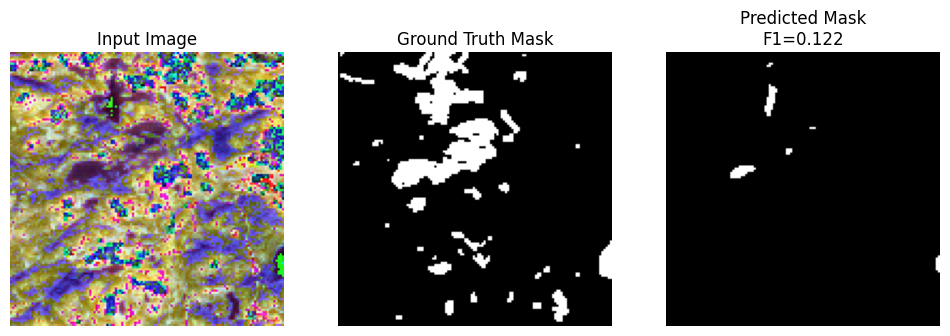

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


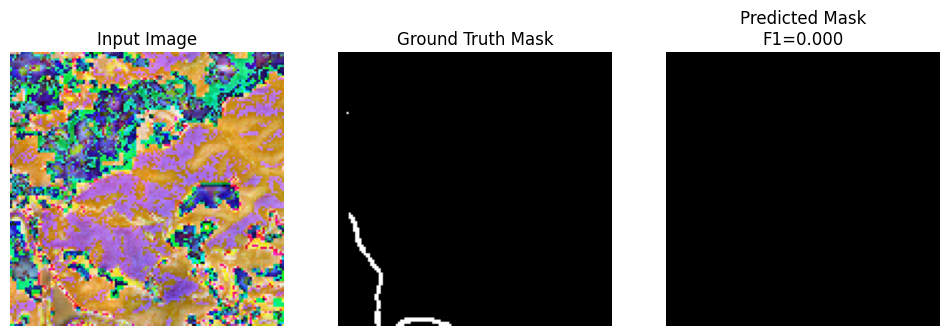

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


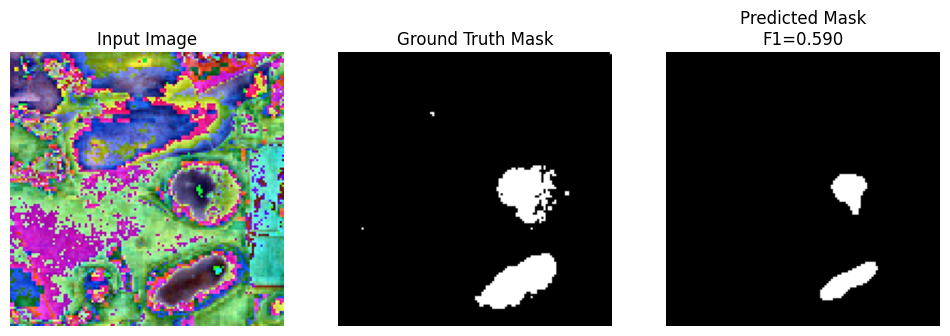

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


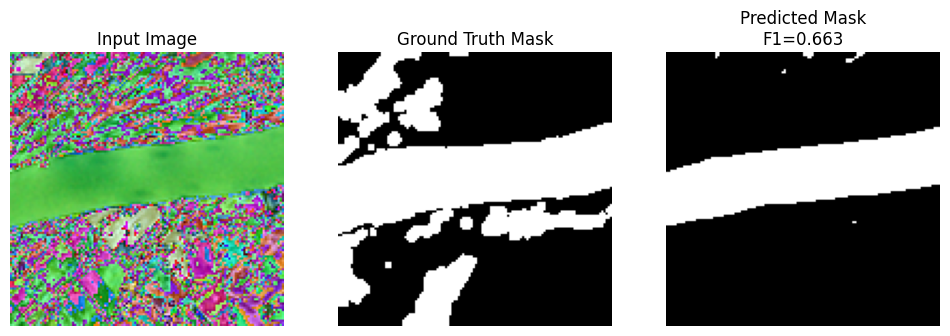

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


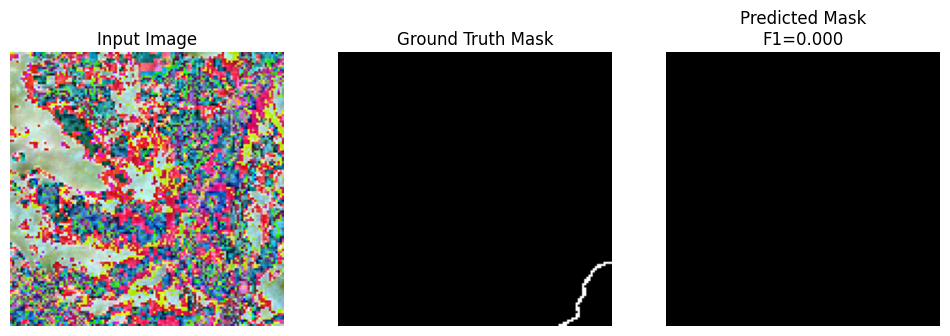

In [15]:
import matplotlib.pyplot as plt

# --- Visualize N samples ---
def visualize_predictions(model, image_files, image_dir, mask_dir, target_size=(128,128), n=5, threshold=0.5):
    for i, img_file in enumerate(image_files[:n]):
        # Load image and mask safely
        img, mask = load_image_mask(img_file, image_dir, mask_dir, target_size)
        pred = model.predict(img[np.newaxis, ...])[0]
        pred_binary = (pred > threshold).astype(np.float32)

        # Compute F1 for this sample
        y_true = mask.flatten()
        y_pred = pred_binary.flatten()
        tp = np.sum(y_true * y_pred)
        fp = np.sum((1 - y_true) * y_pred)
        fn = np.sum(y_true * (1 - y_pred))
        f1 = (2 * tp) / (2 * tp + fp + fn + 1e-7)

        # Plot
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(img[..., :3].astype(np.uint8))  # show first 3 channels as RGB
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(mask[...,0], cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(pred_binary[...,0], cmap='gray')
        plt.title(f"Predicted Mask\nF1={f1:.3f}")
        plt.axis("off")

        plt.show()

# --- Run visualization for first 5 images ---
visualize_predictions(model, image_files, image_dir, mask_dir, n=5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━

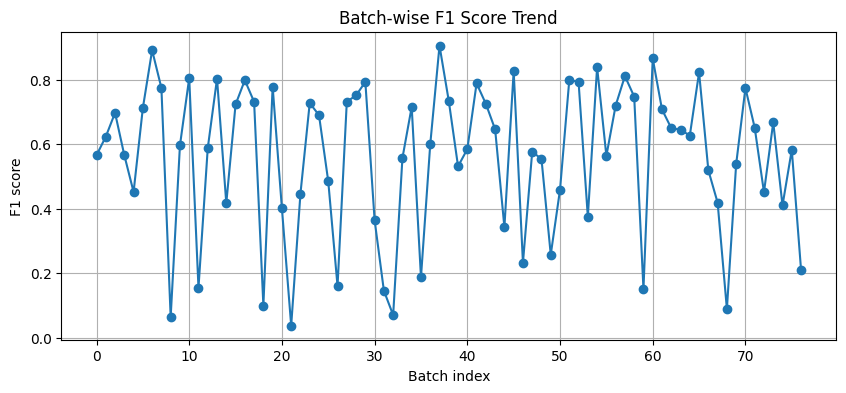

Mean F1 across all batches: 0.5628


In [16]:
import matplotlib.pyplot as plt
import numpy as np

# --- Compute batch-wise F1 and return list of F1 scores ---
def batchwise_f1(model, image_files, image_dir, mask_dir, target_size=(128,128), batch_size=4, threshold=0.5):
    batch_f1_scores = []

    for i in range(0, len(image_files), batch_size):
        batch_files = image_files[i:i+batch_size]
        batch_images = []
        batch_masks = []

        # Load batch safely
        for img_file in batch_files:
            img, mask = load_image_mask(img_file, image_dir, mask_dir, target_size)
            batch_images.append(img)
            batch_masks.append(mask)

        batch_images = np.stack(batch_images, axis=0)
        batch_masks = np.stack(batch_masks, axis=0)

        # Predict
        preds = model.predict(batch_images)
        pred_binary = (preds > threshold).astype(np.float32)

        # Compute F1 for this batch
        y_true = batch_masks.flatten()
        y_pred = pred_binary.flatten()
        tp = np.sum(y_true * y_pred)
        fp = np.sum((1 - y_true) * y_pred)
        fn = np.sum(y_true * (1 - y_pred))
        f1 = (2 * tp) / (2 * tp + fp + fn + 1e-7)
        batch_f1_scores.append(f1)

    return batch_f1_scores

# --- Run batch-wise F1 ---
batch_f1_scores = batchwise_f1(model, image_files, image_dir, mask_dir, batch_size=4)

# --- Plot batch-wise F1 trend ---
plt.figure(figsize=(10,4))
plt.plot(batch_f1_scores, marker='o')
plt.title("Batch-wise F1 Score Trend")
plt.xlabel("Batch index")
plt.ylabel("F1 score")
plt.grid(True)
plt.show()

# --- Print overall mean F1 ---
mean_f1 = np.mean(batch_f1_scores)
print(f"Mean F1 across all batches: {mean_f1:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


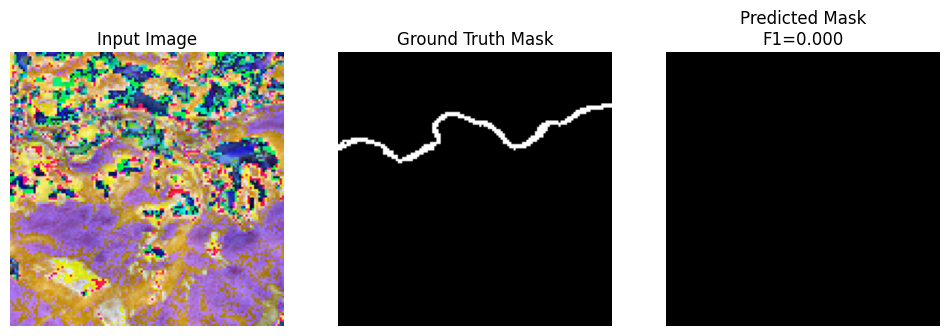

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


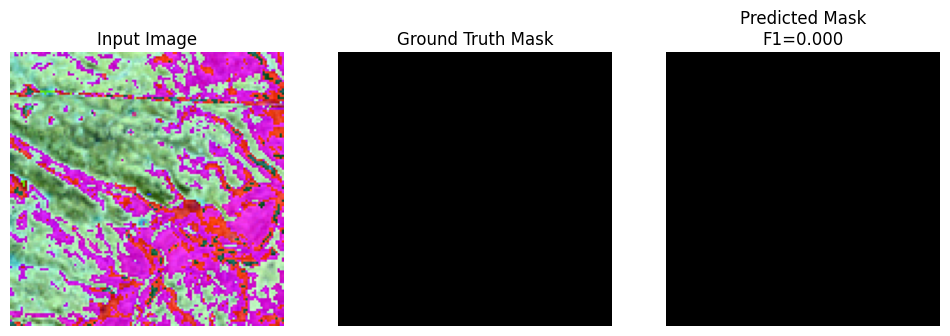

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


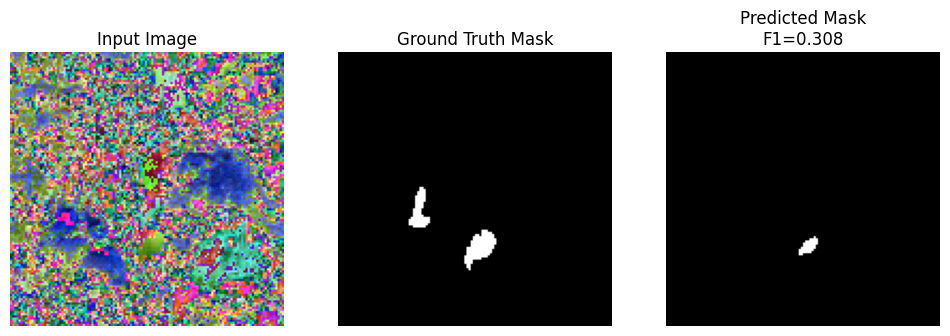

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


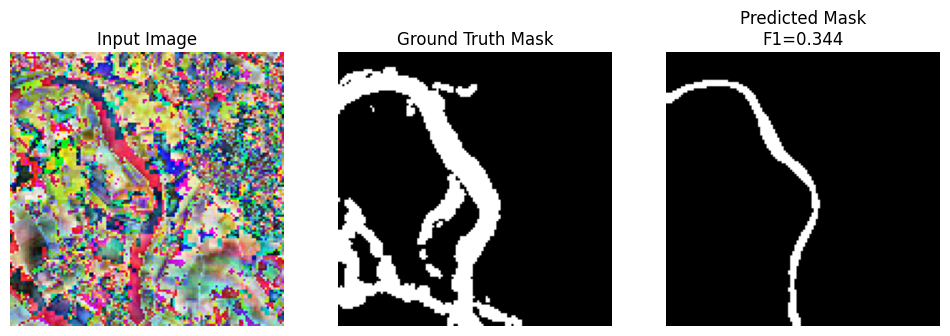

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


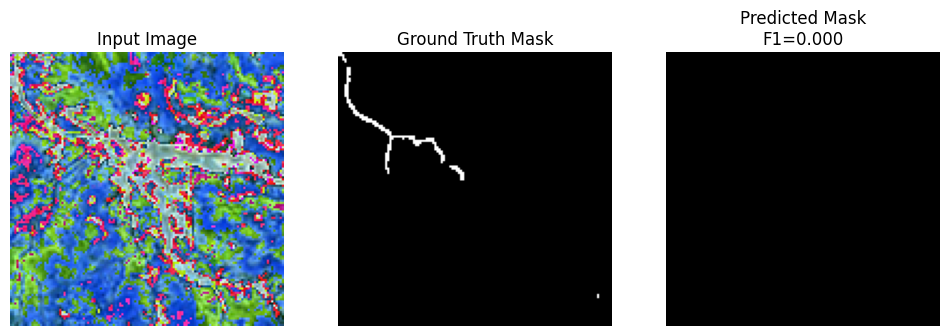

In [17]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tifffile

# Example: list of validation image filenames
val_image_files = image_files[-20:]  # last 20 as validation, adjust as needed

def visualize_val_predictions(model, val_image_files, image_dir, mask_dir, target_size=(128,128), threshold=0.5, n=5):
    for i, img_file in enumerate(val_image_files[:n]):
        # Load image and mask safely
        img, mask = load_image_mask(img_file, image_dir, mask_dir, target_size)
        
        # Predict
        pred = model.predict(img[np.newaxis, ...])[0]
        pred_binary = (pred > threshold).astype(np.float32)

        # Compute F1 for this sample
        y_true = mask.flatten()
        y_pred = pred_binary.flatten()
        tp = np.sum(y_true * y_pred)
        fp = np.sum((1 - y_true) * y_pred)
        fn = np.sum(y_true * (1 - y_pred))
        f1 = (2 * tp) / (2 * tp + fp + fn + 1e-7)

        # Plot input, mask, prediction
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(img[..., :3].astype(np.uint8))  # first 3 channels as RGB
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(mask[...,0], cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(pred_binary[...,0], cmap='gray')
        plt.title(f"Predicted Mask\nF1={f1:.3f}")
        plt.axis("off")

        plt.show()

# --- Run visualization ---
visualize_val_predictions(model, val_image_files, image_dir, mask_dir, n=5)


In [18]:
history = model.fit(

    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=4
)


Epoch 1/4
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 249ms/step - accuracy: 0.8994 - loss: 0.6900 - mean_io_u_1: 0.3740 - val_accuracy: 0.9258 - val_loss: 0.5155 - val_mean_io_u_1: 0.3906
Epoch 2/4
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 248ms/step - accuracy: 0.9003 - loss: 0.6213 - mean_io_u_1: 0.3698 - val_accuracy: 0.9102 - val_loss: 0.5412 - val_mean_io_u_1: 0.3740
Epoch 3/4
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 243ms/step - accuracy: 0.9034 - loss: 0.5905 - mean_io_u_1: 0.3663 - val_accuracy: 0.9119 - val_loss: 0.5454 - val_mean_io_u_1: 0.3750
Epoch 4/4
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 248ms/step - accuracy: 0.9080 - loss: 0.5672 - mean_io_u_1: 0.3668 - val_accuracy: 0.9102 - val_loss: 0.5807 - val_mean_io_u_1: 0.3657


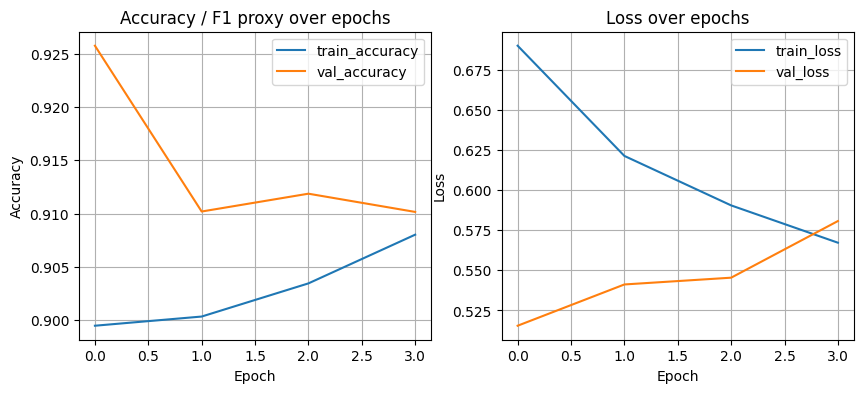

In [21]:
import matplotlib.pyplot as plt

# Assuming you have Keras history object from model.fit() called `history`
# Example: history = model.fit(...)

# Plot training vs validation accuracy or IoU
plt.figure(figsize=(10,4))

# Accuracy / F1 proxy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history.get('val_accuracy', []), label='val_accuracy')
plt.title("Accuracy / F1 proxy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history.get('val_loss', []), label='val_loss')
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


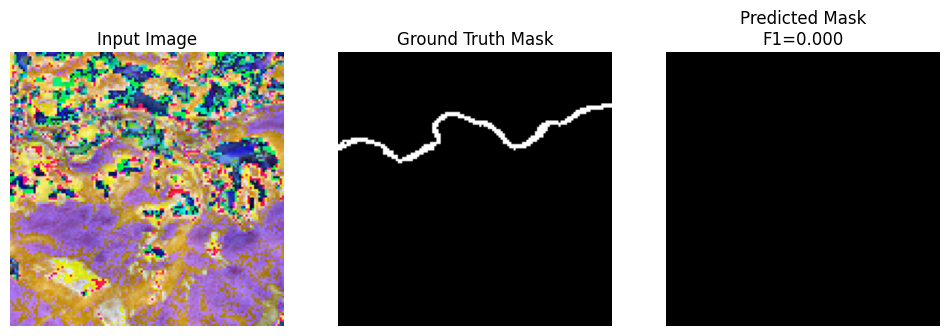

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


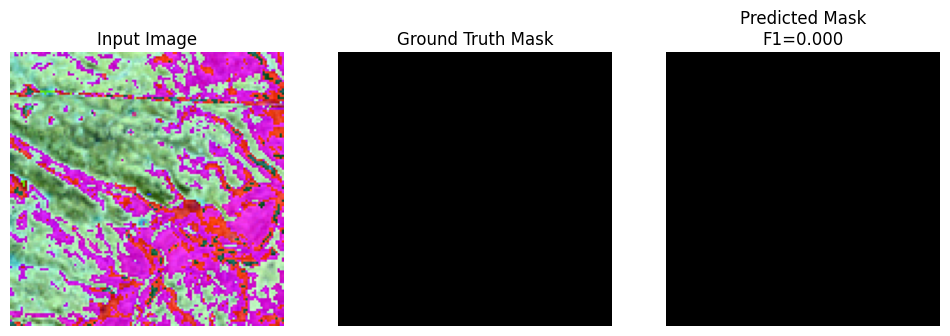

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


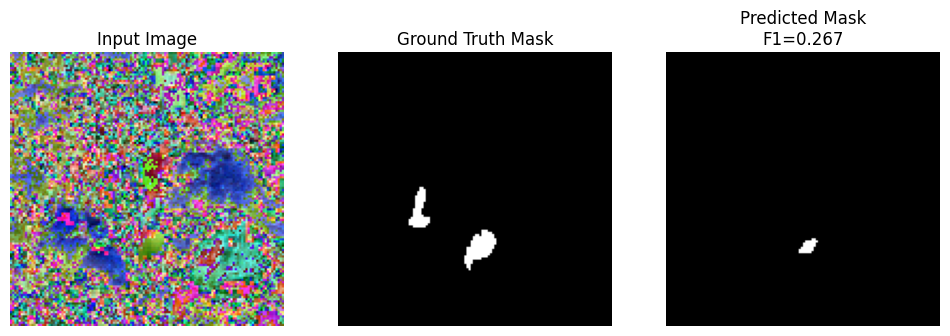

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


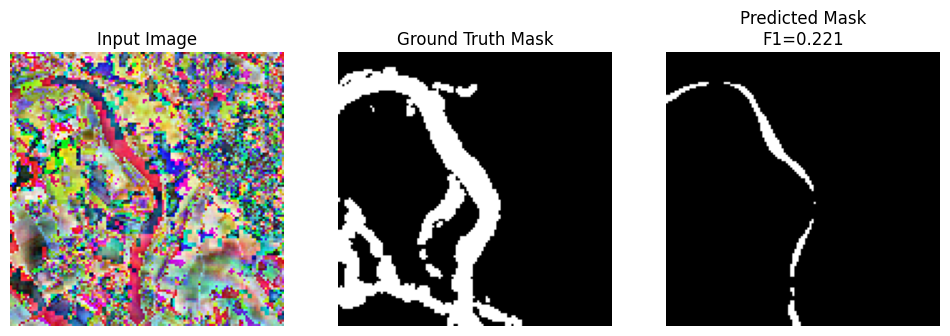

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


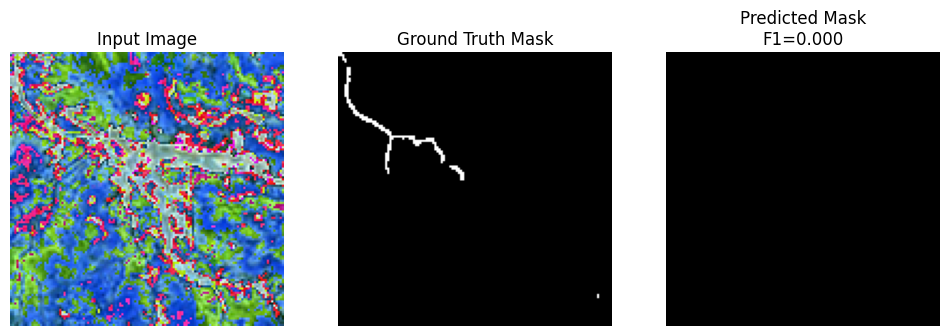

In [22]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tifffile

# Example: list of validation image filenames
val_image_files = image_files[-20:]  # last 20 as validation, adjust as needed

def visualize_val_predictions(model, val_image_files, image_dir, mask_dir, target_size=(128,128), threshold=0.5, n=5):
    for i, img_file in enumerate(val_image_files[:n]):
        # Load image and mask safely
        img, mask = load_image_mask(img_file, image_dir, mask_dir, target_size)
        
        # Predict
        pred = model.predict(img[np.newaxis, ...])[0]
        pred_binary = (pred > threshold).astype(np.float32)

        # Compute F1 for this sample
        y_true = mask.flatten()
        y_pred = pred_binary.flatten()
        tp = np.sum(y_true * y_pred)
        fp = np.sum((1 - y_true) * y_pred)
        fn = np.sum(y_true * (1 - y_pred))
        f1 = (2 * tp) / (2 * tp + fp + fn + 1e-7)

        # Plot input, mask, prediction
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(img[..., :3].astype(np.uint8))  # first 3 channels as RGB
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(mask[...,0], cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(pred_binary[...,0], cmap='gray')
        plt.title(f"Predicted Mask\nF1={f1:.3f}")
        plt.axis("off")

        plt.show()

# --- Run visualization ---
visualize_val_predictions(model, val_image_files, image_dir, mask_dir, n=5)

In [23]:
def load_image_mask(img_file, image_dir, mask_dir, target_size=(128,128)):
    import tifffile
    from PIL import Image
    import numpy as np
    import os

    # --- Load image ---
    img_path = os.path.join(image_dir, img_file)
    img = tifffile.imread(img_path).astype(np.float32)

    # Keep exactly 12 channels
    if img.ndim == 2:
        img = np.stack([img]*12, axis=-1)
    elif img.ndim == 3 and img.shape[-1] < 12:
        pad_width = 12 - img.shape[-1]
        img = np.concatenate([img, np.zeros((*img.shape[:2], pad_width), dtype=img.dtype)], axis=-1)
    elif img.ndim == 3 and img.shape[-1] > 12:
        img = img[..., :12]

    # Optional: normalize per channel
    img_max = np.max(img, axis=(0,1), keepdims=True)
    img_max[img_max==0] = 1
    img = img / img_max

    # Resize each channel
    img_resized = []
    from PIL import Image
    for ch in range(12):
        ch_img = Image.fromarray((img[..., ch]*255).astype(np.uint8))
        ch_img = ch_img.resize(target_size, Image.Resampling.BILINEAR)
        img_resized.append(np.array(ch_img, dtype=np.float32)/255.0)
    img = np.stack(img_resized, axis=-1)

    # --- Load mask ---
    mask_file = img_file.replace(".tif", ".png")
    mask_path = os.path.join(mask_dir, mask_file)
    mask = Image.open(mask_path).convert("L")
    mask = mask.resize(target_size, Image.Resampling.NEAREST)
    mask = np.expand_dims(np.array(mask, dtype=np.float32)/255.0, axis=-1)

    return img, mask


In [24]:
img, mask = load_image_mask("0.tif", image_dir, mask_dir)
pred = model.predict(img[np.newaxis, ...])[0]  # keep batch dimension
pred_binary = (pred > 0.5).astype(np.float32)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [25]:
predictions = []
for img_file in val_image_files:
    img, mask = load_image_mask(img_file, image_dir, mask_dir)
    pred = model.predict(img[np.newaxis, ...])[0]
    predictions.append(pred)
predictions = np.array(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [26]:
import numpy as np
from PIL import Image
import tifffile
import os

def load_image_mask(img_file, image_dir, mask_dir, target_size=(128,128)):
    """Load one image and its mask, keep 12 channels, normalize image only."""
    # --- Load image ---
    img_path = os.path.join(image_dir, img_file)
    img = tifffile.imread(img_path).astype(np.float32)

    # Keep exactly 12 channels
    if img.ndim == 2:
        img = np.stack([img]*12, axis=-1)
    elif img.ndim == 3 and img.shape[-1] < 12:
        pad_width = 12 - img.shape[-1]
        img = np.concatenate([img, np.zeros((*img.shape[:2], pad_width), dtype=img.dtype)], axis=-1)
    elif img.ndim == 3 and img.shape[-1] > 12:
        img = img[..., :12]

    # Normalize per channel
    img_max = np.max(img, axis=(0,1), keepdims=True)
    img_max[img_max==0] = 1
    img = img / img_max

    # Resize each channel
    img_resized = []
    for ch in range(12):
        ch_img = Image.fromarray((img[..., ch]*255).astype(np.uint8))
        ch_img = ch_img.resize(target_size, Image.Resampling.BILINEAR)
        img_resized.append(np.array(ch_img, dtype=np.float32)/255.0)
    img = np.stack(img_resized, axis=-1)

    # --- Load mask ---
    mask_file = img_file.replace(".tif", ".png")
    mask_path = os.path.join(mask_dir, mask_file)
    mask = Image.open(mask_path).convert("L")
    mask = mask.resize(target_size, Image.Resampling.NEAREST)
    mask = np.expand_dims(np.array(mask, dtype=np.float32)/255.0, axis=-1)

    return img, mask

def predict_val_set(model, val_image_files, image_dir, mask_dir, target_size=(128,128), threshold=0.5):
    f1_scores = []
    for img_file in val_image_files:
        img, mask = load_image_mask(img_file, image_dir, mask_dir, target_size)
        pred = model.predict(img[np.newaxis, ...])[0]  # add batch dimension
        pred_binary = (pred > threshold).astype(np.float32)

        # Compute F1 for this image
        y_true = mask.flatten()
        y_pred = pred_binary.flatten()
        tp = np.sum(y_true * y_pred)
        fp = np.sum((1 - y_true) * y_pred)
        fn = np.sum(y_true * (1 - y_pred))
        f1 = (2 * tp) / (2 * tp + fp + fn + 1e-7)
        f1_scores.append(f1)

    mean_f1 = np.mean(f1_scores)
    return f1_scores, mean_f1

# --- Example usage ---
val_image_files = image_files[-20:]  # adjust to your validation set
f1_scores, mean_f1 = predict_val_set(model, val_image_files, image_dir, mask_dir)

print("F1 per image:", f1_scores)
print("Mean F1 across validation set:", mean_f1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
F1 per image: [np.float32(0.004366018), np.float32(0.0), np.float32(0.0069605964), np.float32(0.0072975154), np.float32(0.0), np.float32(0.00719724), np.float32(0.006335728), np.float32(0.0), np.float32(0.007353662), np.float32(0.0065629017

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


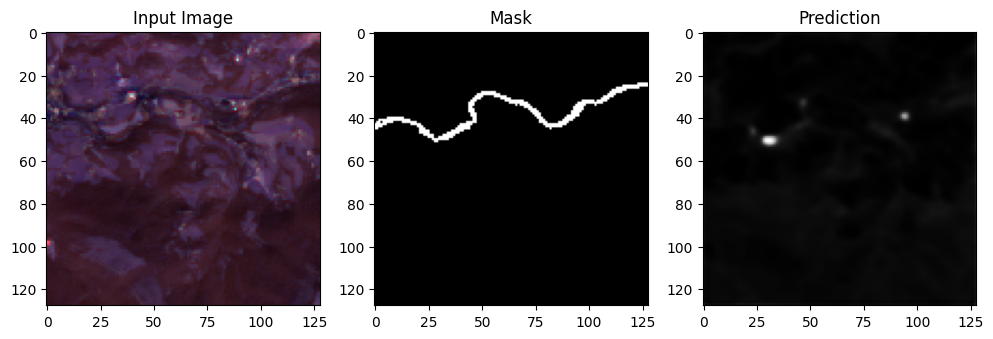

In [39]:
import matplotlib.pyplot as plt

img, mask = load_image_mask(val_image_files[0], image_dir, mask_dir)
pred = model.predict(img[np.newaxis,...])[0]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img[..., :3])  # first 3 channels for viewing
plt.title("Input Image")

plt.subplot(1,3,2)
plt.imshow(mask[...,0], cmap='gray')
plt.title("Mask")

plt.subplot(1,3,3)
plt.imshow(pred[...,0], cmap='gray')
plt.title("Prediction")
plt.show()


In [40]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_12ch_prediction(img, mask, pred, channels_to_rgb=[0,1,2], threshold=0.5):
    """
    img: numpy array of shape (H, W, 12)
    mask: numpy array of shape (H, W, 1) or (H, W)
    pred: numpy array of shape (H, W, 1)
    channels_to_rgb: which 3 channels to display as RGB
    threshold: threshold to binarize prediction
    """
    # Make prediction binary
    pred_binary = (pred > threshold).astype(np.float32)
    
    # Prepare RGB image for viewing
    if img.shape[-1] >= 3:
        rgb_img = img[..., channels_to_rgb]
        # normalize to 0-1 for matplotlib if not already
        rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min() + 1e-8)
    else:
        rgb_img = img[..., 0]  # fallback to single channel
    
    plt.figure(figsize=(12,4))
    
    # Input
    plt.subplot(1,3,1)
    plt.imshow(rgb_img)
    plt.title("Input Image (channels {})".format(channels_to_rgb))
    plt.axis("off")
    
    # Ground truth mask
    plt.subplot(1,3,2)
    plt.imshow(mask[...,0] if mask.ndim==3 else mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")
    
    # Predicted mask
    plt.subplot(1,3,3)
    plt.imshow(pred_binary[...,0] if pred_binary.ndim==3 else pred_binary, cmap='gray')
    plt.title("Predicted Mask (threshold={})".format(threshold))
    plt.axis("off")
    
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


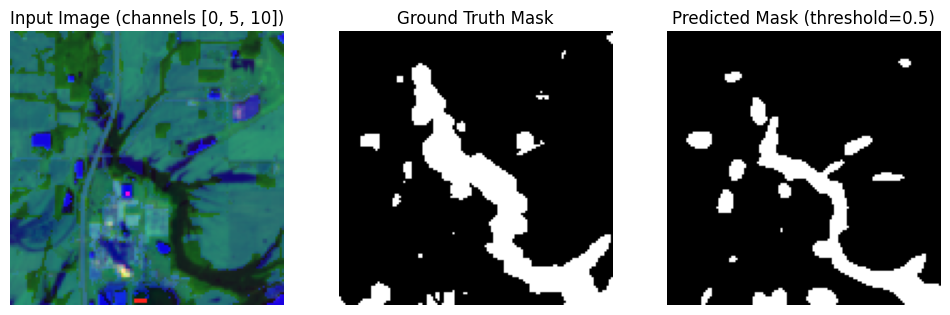

In [57]:
# Pick one validation image
img_file = val_image_files[14]
img, mask = load_image_mask(img_file, image_dir, mask_dir)  # your existing loader

# Predict using all 12 channels
pred = model.predict(img[np.newaxis,...])[0]

# Visualize safely
visualize_12ch_prediction(img, mask, pred, channels_to_rgb=[0,5,10], threshold=0.5)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_val_predictions_12ch(model, val_image_files, image_dir, mask_dir, 
                                    target_size=(128,128), threshold=0.5, 
                                    channels_to_rgb=[0,5,10], n=5):
    """
    Visualize predictions for n validation images using all 12 channels.
    
    model: trained UNet model
    val_image_files: list of validation image filenames
    image_dir: folder containing images
    mask_dir: folder containing masks
    target_size: resize images/masks for the model
    threshold: probability threshold to binarize predictions
    channels_to_rgb: which 3 channels to use for RGB visualization
    n: number of images to visualize
    """
    f1_scores = []

    for i, img_file in enumerate(val_image_files[:n]):
        # Load image and mask
        img, mask = load_image_mask(img_file, image_dir, mask_dir, target_size)
        
        # Predict
        pred = model.predict(img[np.newaxis,...])[0]
        pred_binary = (pred > threshold).astype(np.float32)
        
        # Compute F1
        y_true = mask.flatten()
        y_pred = pred_binary.flatten()
        tp = np.sum(y_true * y_pred)
        fp = np.sum((1 - y_true) * y_pred)
        fn = np.sum(y_true * (1 - y_pred))
        f1 = (2 * tp) / (2 * tp + fp + fn + 1e-7)
        f1_scores.append(f1)
        
        # Prepare RGB image for visualization
        rgb_img = img[..., channels_to_rgb]
        rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min() + 1e-8)
        
        # Plot
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(rgb_img)
        plt.title(f"Input Image (channels {channels_to_rgb})")
        plt.axis("off")
        
        plt.subplot(1,3,2)
        plt.imshow(mask[...,0] if mask.ndim==3 else mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")
        
        plt.subplot(1,3,3)
        plt.imshow(pred_binary[...,0] if pred_binary.ndim==3 else pred_binary, cmap='gray')
        plt.title(f"Predicted Mask\nF1={f1:.3f}")
        plt.axis("off")
        
        plt.show()

    mean_f1 = np.mean(f1_scores)
    print(f"Mean F1 across {n} validation images: {mean_f1:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


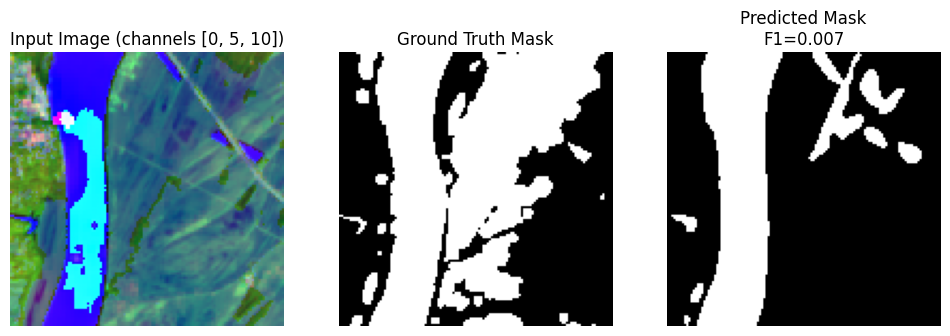

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


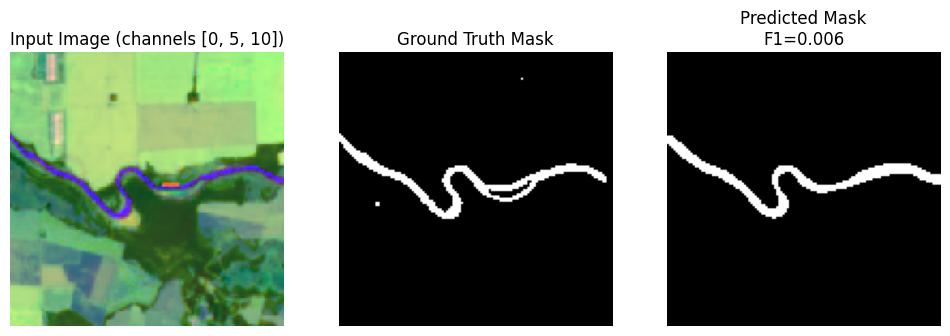

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


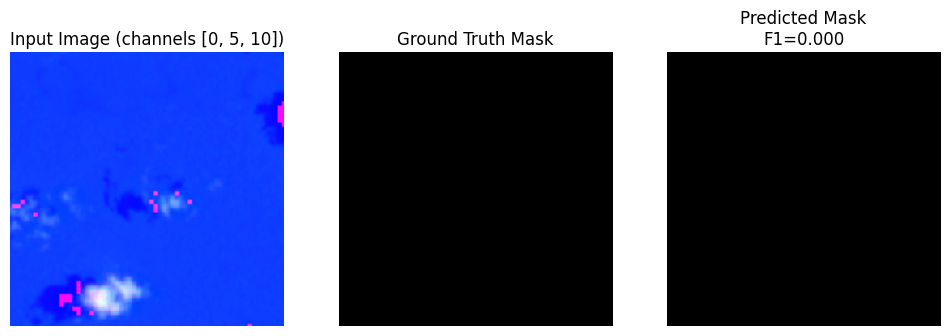

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


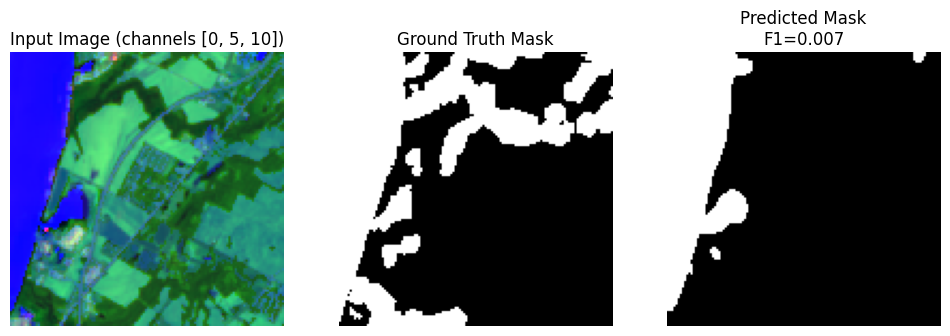

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


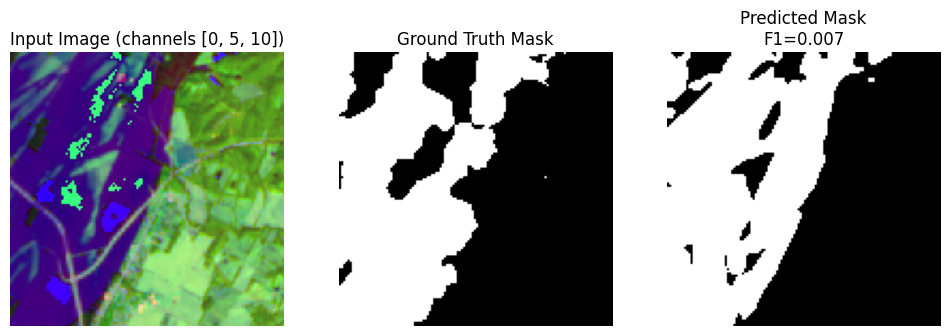

Mean F1 across 5 validation images: 0.0055


In [62]:
visualize_val_predictions_12ch(
    model=model,
    val_image_files=val_image_files[5:10],
    image_dir=image_dir,
    mask_dir=mask_dir,
    target_size=(128,128),
    threshold=0.5,
    channels_to_rgb=[0,5,10],  # pick any 3 channels for viewing
    n=5  # number of validation images to visualize
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


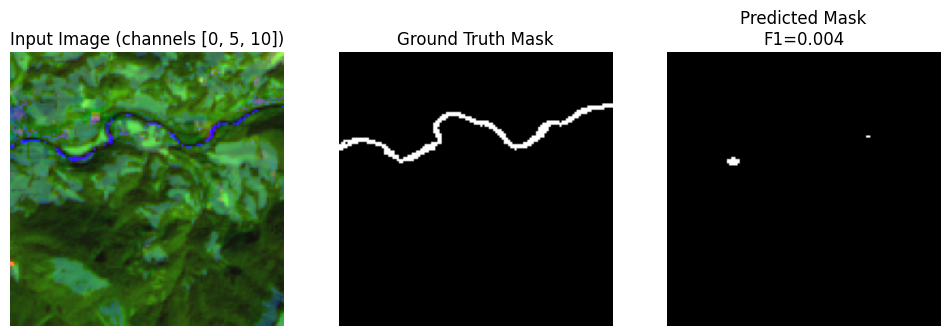

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


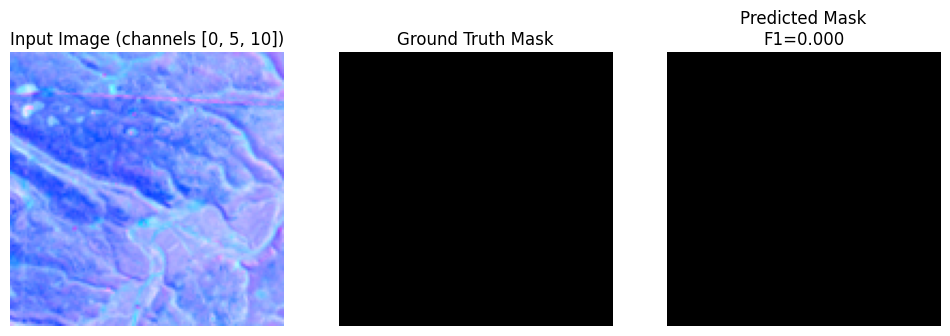

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


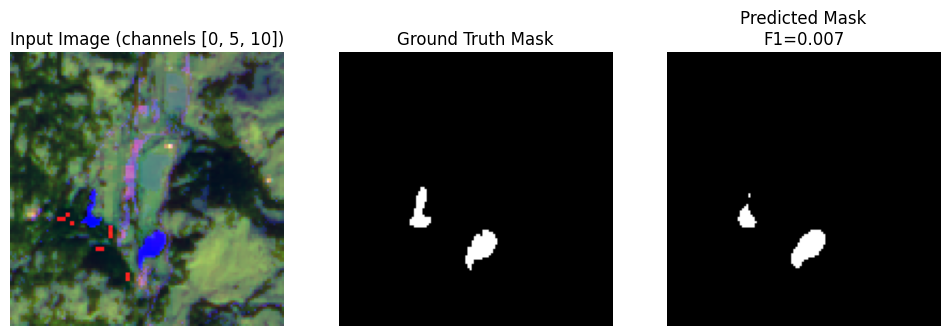

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


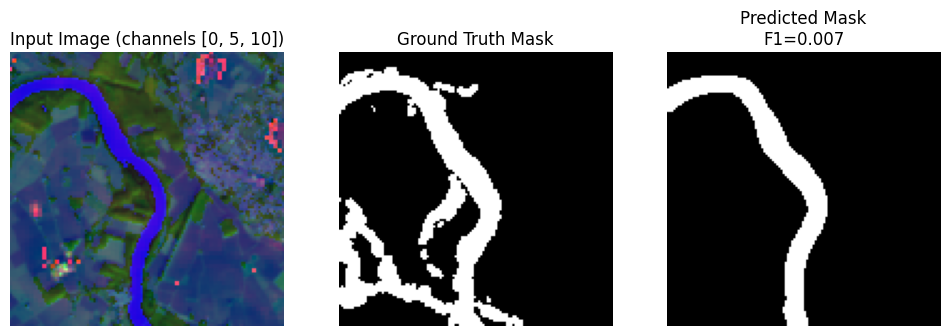

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


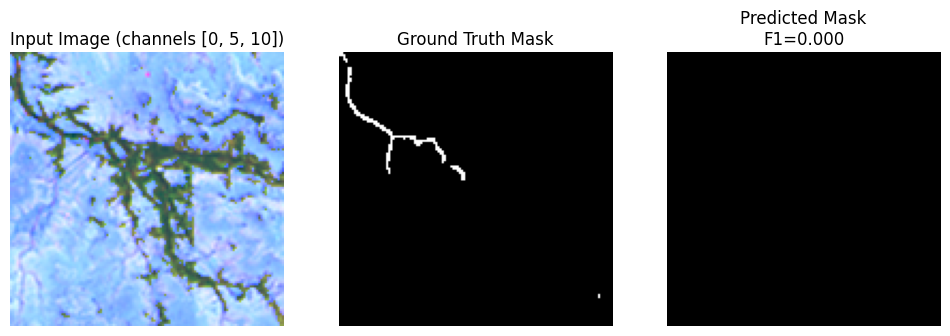

Mean F1 across 5 validation images: 0.0037


In [64]:
visualize_val_predictions_12ch(
    model=model,
    val_image_files=val_image_files[:5],
    image_dir=image_dir,
    mask_dir=mask_dir,
    target_size=(128,128),
    threshold=0.5,
    channels_to_rgb=[0,5,10],  # pick any 3 channels for viewing
    n=5  # number of validation images to visualize
)
